In [1]:
from scipy.spatial import distance
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tsplib95

In [2]:
class ACA:   # imported from Scikit-opt
    def __init__(self, func, n_dim, size_pop, max_iter, distance_matrix, alpha, beta, rho):
        self.func = func
        self.n_dim = n_dim
        self.size_pop = size_pop
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho

        self.prob_matrix_distance = 1 / (distance_matrix + 1e-10 * np.eye(n_dim, n_dim))

        self.Tau = np.ones((n_dim, n_dim))
        self.Table = np.zeros((size_pop, n_dim)).astype(np.int)
        self.y = None
        self.generation_best_X, self.generation_best_Y = [], []
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y 
        self.best_x, self.best_y = None, None

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta
            for j in range(self.size_pop):
                self.Table[j, 0] = 0
                for k in range(self.n_dim - 1):
                    taboo_set = set(self.Table[j, :k + 1])
                    allow_list = list(set(range(self.n_dim)) - taboo_set)
                    prob = prob_matrix[self.Table[j, k], allow_list]
                    prob = prob / prob.sum()
                    next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                    self.Table[j, k + 1] = next_point

            y = np.array([self.func(i) for i in self.Table])
            
            index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            delta_tau = np.zeros((self.n_dim, self.n_dim))
            for j in range(self.size_pop):
                for k in range(self.n_dim - 1):
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]
                    delta_tau[n1, n2] += 1 / y[j]
                n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]
                delta_tau[n1, n2] += 1 / y[j]

            self.Tau = (1 - self.rho) * self.Tau + delta_tau

        best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        return self.best_x, self.best_y

    fit = run

In [3]:
load = tsplib95.load('./tsp-qa194.tsp')


QATAR dimension 194 

Ant Colony Algorithm parameters: 

- Population size = 10 ind. 
- Alpha = 0.5 
- Beta = 5 
- Rho = 0.5 

Stopping criterion: 200 iterations 

Computation time = 35.58416032791138 sec. 

Convergence curve:


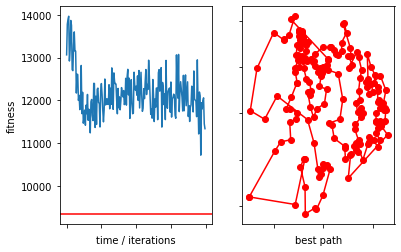

Minimal distance 10723.744356894627 [ fitness = 1371.7443568946273 ] is reached for path:

 [  0   5   7  15  12  22  24  13  10  16  23  25  20  17  27  28  21  26
  36  38  33  39  42  40  45  47  51  52  53  54  48  41  43  37  30  31
  29  34  49  55  57  46  50  60  66  65  72  67  63  56  44  32  59  68
  73  77  74  71  75  79  86 101 102  90  92  95  94  96  91  87  82  78
  80  76  69  83  99 109 111 114 115 116 120 119 127 123 122 132 134 128
 135 130 142 147 154 150 146 151 140 143 149 152 156 153 138 137 145 148
 144 139 136 141 155 160 162 163 168 175 181 171 178 173 172 174 183 180
 176 177 179 169 170 165 159 161 157 158 164 167 166 184 192 187 188 190
 191 189 186 182 185 193 129 133 131 126 124 125 113 112 108 118 121 117
 105 104 106 107  14  18  11   9   8   4   2   1   3   6  70  81  88  89
  93  98 100 103 110  97  85  84  64  62  35  58  61  19]


In [4]:
# input data
known_optimum = 9352
coordinates = np.array([load.node_coords[point] for point in list(load.get_nodes())])
dimension = coordinates.shape[0]
distance_matrix = distance.cdist(coordinates, coordinates, metric='euclidean')

# objective function
def total_distance(select):
    return np.sum([distance_matrix[select[i % dimension], select[(i + 1) % dimension]] for i in range(dimension)])

# search parameters
population = 10 # 10
alpha = 0.5 # 1
beta = 5 # 2
rho = 0.5 # 0.1
iterations = 200

# run search
t1 = time()
aca = ACA(func=total_distance, n_dim=dimension, size_pop=population, max_iter=iterations, distance_matrix=distance_matrix, alpha=alpha, beta=beta, rho=rho)
best_path, best_distance = aca.run()
t2 = time()

# display results
print('\nQATAR dimension', dimension, '\n\nAnt Colony Algorithm parameters:', '\n\n- Population size =', population, 'ind.', '\n- Alpha =', alpha, '\n- Beta =', beta, '\n- Rho =', rho,  '\n\nStopping criterion:', iterations, 'iterations', '\n\nComputation time =', t2-t1, 'sec.', '\n\nConvergence curve:')
fig, ax = plt.subplots(1, 2)
ax[0].axhline(y=known_optimum, color='red')
ax[0].set_ylabel('fitness')
ax[0].set_xlabel('time / iterations')
ax[0].set_xticklabels([])
ax[0].plot(aca.generation_best_Y)
best_path_ = np.concatenate([best_path, [best_path[0]]])
best_coordinates = coordinates[best_path_, :]
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlabel('best path')
ax[1].plot(best_coordinates[:, 0], best_coordinates[:, 1], 'o-r')
plt.show()
print('Minimal distance', best_distance, '[ fitness =', best_distance-known_optimum,'] is reached for path:\n\n', best_path)